## Dataset Setup

In [65]:
import pathlib, os, sys, operator, re, datetime
from functools import reduce
import numpy as np
import tensorflow as tf
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Model
import tensorflow_datasets as tfds
from tiny_imagenet import TinyImagenetDataset

# Enable or disable GPU
# To fully disable it, we need to hide all GPU devices from Tensorflow
# Make sure GPU is disabled for this inference part of the lab
ENABLE_GPU = False
# tf.debugging.set_log_device_placement(True)

if not ENABLE_GPU:
    tf.config.set_visible_devices([], 'GPU')

# Print Python and TF version, and where we are running
print(f'Running on Python Version: {sys.version}')
print(f'Using Tensorflow Version: {tf. __version__}')
if not tf.config.experimental.list_physical_devices("GPU"):
    print('Running on CPU')
else:
    print(f'Using GPU at: {tf.test.gpu_device_name()} (of {len(tf.config.experimental.list_physical_devices("GPU"))} available)')

Running on Python Version: 3.6.8 (default, May 31 2023, 10:28:59) 
[GCC 8.5.0 20210514 (Red Hat 8.5.0-18)]
Using Tensorflow Version: 2.6.2
Running on CPU


In [66]:
# Original Source: https://github.com/ksachdeva/tiny-imagenet-tfds
# Class Version Source: https://github.com/Mluckydwyer/tiny-imagenet-tfds
# Setup our dataset
# ---------------------------------------------------------

tiny_imagenet_builder = TinyImagenetDataset()

# this call (download_and_prepare) will trigger the download of the dataset
# and preparation (conversion to tfrecords)
#
# This will be done only once and on next usage tfds will
# use the cached version on your host.
tiny_imagenet_builder.download_and_prepare(download_dir="~/tensorflow-datasets/downloads")

# class_names = tiny_imagenet_builder.info.features['label'].names
ds = tiny_imagenet_builder.as_dataset()
ds_train, ds_val = ds["train"], ds["validation"]
assert(isinstance(ds_train, tf.data.Dataset))
assert(isinstance(ds_val, tf.data.Dataset))

# Training Dataset
ds_train = ds_train.shuffle(1024).prefetch(tf.data.AUTOTUNE)

# Validation Dataset
ds_val = ds_val.shuffle(1024).prefetch(tf.data.AUTOTUNE)

# Dataset metadata
ds_info = tiny_imagenet_builder.info

## Working with the Dataset

In [67]:
# We need to read the "human readable" labels so we can translate with the numeric values
# Read the labels file (words.txt)
with open(os.path.abspath('wnids.txt'), 'r') as f:
    wnids = [x.strip() for x in f]

# Map wnids to integer labels
wnid_to_label = {wnid: i for i, wnid in enumerate(wnids)}
label_to_wnid = {v: k for k, v in wnid_to_label.items()}

# Use words.txt to get names for each class
with open(os.path.abspath('words.txt'), 'r') as f:
    wnid_to_words = dict(line.split('\t') for line in f)
    for wnid, words in wnid_to_words.items():
        wnid_to_words[wnid] = [w.strip() for w in words.split(',')]
        
class_names = [str(wnid_to_words[wnid]) for wnid in wnids]

In [68]:
# Helper function to get the label name
def img_class(img_data, idx=None):
    image, label, id, label_name = img_data["image"], img_data["label"], img_data["id"], img_data["metadata"]['label_name']
    # Handle batches of images correctly
    if idx != None:
        image, label, id, label_name = img_data["image"][idx], img_data["label"][idx], img_data["id"][idx], img_data["metadata"]['label_name'][idx]
    
    return f"{label_name} (class index: {label} - id: {id})"


# Helper function to show basic info about an image
def img_info(img, idx=None, display=True, title_apend=""):
    image = img['image']

    # Print the clas
    class_str = img_class(img, idx)
    print(f"Label: {class_str}")
    
    # Display the image
    if display:
        plt.figure()
        plt.title(title_apend + class_str)
        # Handle batches correctly
        if image.shape.ndims > 3:
            plt.imshow(image.numpy().reshape(64, 64, 3))
        else:
            plt.imshow(image.numpy())

--- Train & Validation dataset info ---
Train: <PrefetchDataset shapes: {id: (), image: (64, 64, 3), label: (), metadata: {label_name: ()}}, types: {id: tf.string, image: tf.uint8, label: tf.int64, metadata: {label_name: tf.string}}>
Validation: <PrefetchDataset shapes: {id: (), image: (64, 64, 3), label: (), metadata: {label_name: ()}}, types: {id: tf.string, image: tf.uint8, label: tf.int64, metadata: {label_name: tf.string}}>

--- Show an example image ---
Label: b'sports car, sport car' (class index: 117 - id: b'n04285008')

 Show some other examples


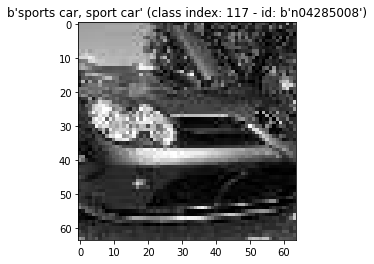

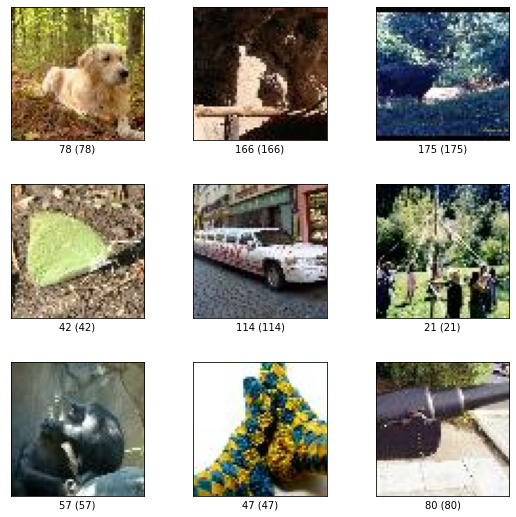

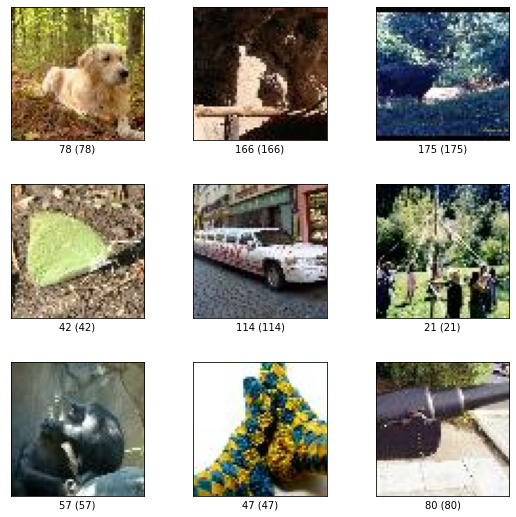

In [69]:
# Print the dataset types and info
print("--- Train & Validation dataset info ---")
print(f"Train: {ds_train}")
print(f"Validation: {ds_val}")
# print(f"Dataset Info: {ds_info}") # Uncomment to print Dataset info

print("\n--- Show an example image ---")
for example in ds_val.take(1):
    img_info(example)

print("\n Show some other examples")
tfds.show_examples(ds_val, ds_info, rows=3, cols=3)


--- Image 0 ---
Label: [b'sandal'] (class index: [97] - id: [b'n04133789'])
Image dimensions: (1, 64, 64, 3)
Image dtype: <dtype: 'uint8'>
Image mem req: 4096

--- Image 1 ---
Label: [b'gazelle'] (class index: [73] - id: [b'n02423022'])
Image dimensions: (1, 64, 64, 3)
Image dtype: <dtype: 'uint8'>
Image mem req: 4096

--- Image 2 ---
Label: [b'guacamole'] (class index: [53] - id: [b'n07583066'])
Image dimensions: (1, 64, 64, 3)
Image dtype: <dtype: 'uint8'>
Image mem req: 4096


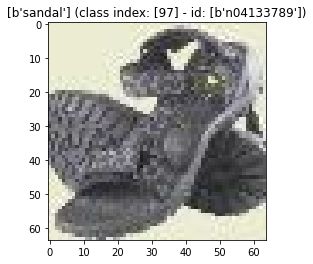

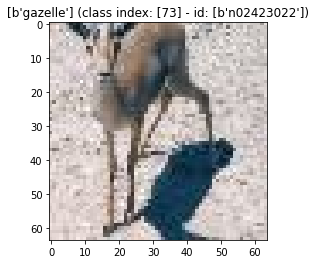

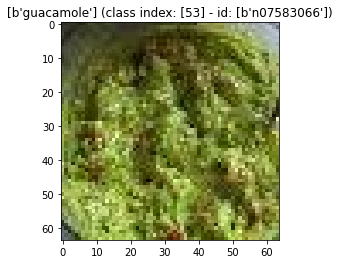

In [70]:
# TODO: Print and visualize three inputs from the validation set
#     : Print the storage data type
#     : Print and note the dimensions of each image
#     : Print the memory required to store each image

# Sample Images
sample_imgs = []
for index, img_data in enumerate(ds_val.batch(1).take(3)): #added batch(1)
    sample_imgs.append(img_data)
    image, label, id, label_name = img_data["image"], img_data["label"], img_data["id"], img_data["metadata"]['label_name']

    print(f'\n--- Image {index} ---')
    # TODO: Your Code Here
    img_info(img_data)
    print(f'Image dimensions: {image.shape}')
    print(f'Image dtype: {image.dtype}')
    mem = image.shape[0] * image.shape[1] * image.shape[2]
    print(f'Image mem req: {mem}')




In [71]:
# TODO: Export each of the three inputs to a binary file which will be used to load the images into C++ later
# NOTE: First flatten the array (ex: 4D --> 1D). So 64*64*3 = 12288 element 1D array

# Make a directory for our image data
img_dir = os.path.abspath('img_data')
pathlib.Path(img_dir).mkdir(exist_ok=True)

# Create a metadata file
metadata_file = open(os.path.join(img_dir, f'metadata.txt'), 'w')
metadata_file.write(f'Number\t\tDims\t\tClass Data\n')

# Export each image
for index, img_data in enumerate(sample_imgs):    
    img_file = open(os.path.join(img_dir, f'image_{index}.bin'), 'wb')
    
    # TODO: Your Code Here

    array = image.numpy()
    flatArr = np.ndarray.flatten(array)
    binary = np.vectorize(np.binary_repr)(flatArr)

    img_file.write(binary)

    img_file.close()

    # Write the image metadata for reference later
    class_str = img_class(img_data)
    metadata_file.write(f'{index}\t\t{img_data["image"].shape}\t\t{class_str}\n')
metadata_file.close()

## Model Setup

In [72]:
# TODO: Load the model
# Now we will load the H5 model! Please make sure the h5 model file is present in the below directory.
# You can download this from the Canvas Page and place it in the same directory as this notebook.

# model_path = os.path.abspath(""/home/dwyer/482/dev/CNN_TinyImageNet_2.h5)" # Uncomment this to use a non-relative path
model_path = os.path.abspath("CNN_TinyImageNet_2.h5")

# TODO: Your Code Here
model = tf.keras.models.load_model(model_path)


# TODO: Print a summary of the model
# NOTE: https://www.tensorflow.org/versions/r2.6/api_docs/python/tf/keras/Model

# TODO: Your Code Here


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 60, 32)        2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 64)        3

# Running Infrence

Label: [b'teddy, teddy bear'] (class index: [144] - id: [b'n04399382'])
Best Guess [class index]: ['teapot'] [71]
Best Guess Confidence (percent / 1.0): [0.99998593]
Top 15 Guesses (class index): ['[ [71]', '[ [191]', '[ [190]', '[ [38]', '[ [134]', '[ [137]', '[ [136]', '[ [74]', '[ [0]', '[ [1]', '[ [2]', '[ [3]', '[ [4]', '[ [5]', '[ [6]']
Top 15 Guesses Confidence (percent / 1.0): [[9.9998593e-01 1.2726373e-05 1.2939259e-06 3.9262167e-09 9.9765340e-10
  3.1978135e-11 1.0422448e-12 7.3509436e-37 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]]


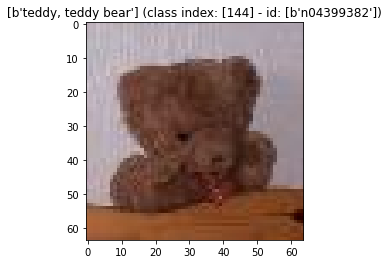

In [78]:
# Running infrence on our model
# We can run an infrence of our model by doing the following (we are doing batches of 1 here)
for example in ds_train.batch(1).take(1):
    img_info(example)
    
    # Make a prediction
    pred = model.predict(example["image"])
    # print(f'Raw 200 Class Weighted Prediction:\n{pred}') # Uncomment to see the raw prediction
    
    # What is out best guess?
    best_guess = tf.math.argmax(pred, axis=1).numpy() # Our output is 200 weighted value, we want the most likely
    print(f'Best Guess [class index]: {class_names[best_guess[0]]} [{best_guess[0]}]')
    print(f'Best Guess Confidence (percent / 1.0): {pred[0][best_guess]}')

    # What are our top 15 guesses?
    top_15 = tf.math.top_k(pred, k=15)
    print(f'Top 15 Guesses (class index): {[f"{class_names[idx][0]} [{idx}]" for idx in top_15.indices[0]]}')
    print(f'Top 15 Guesses Confidence (percent / 1.0): {top_15.values}')

Label: [b'sandal'] (class index: [97] - id: [b'n04133789'])
Image dimensions: (1, 64, 64, 3)
Image dtype: <dtype: 'uint8'>
Best Guess [class index]: ['backpack', 'back pack', 'knapsack', 'packsack', 'rucksack', 'haversack'] [38]
Best Guess Confidence (percent / 1.0): [1.]
Top 15 Guesses (class index): ['[ [38]', '[ [134]', '[ [172]', '[ [109]', '[ [0]', '[ [1]', '[ [2]', '[ [3]', '[ [4]', '[ [5]', '[ [6]', '[ [7]', '[ [8]', '[ [9]', '[ [10]']
Top 15 Guesses Confidence (percent / 1.0): [[1.0000000e+00 3.5019835e-24 2.0204982e-34 2.6151667e-35 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]]
Label: [b'gazelle'] (class index: [73] - id: [b'n02423022'])
Image dimensions: (1, 64, 64, 3)
Image dtype: <dtype: 'uint8'>
Best Guess [class index]: ['kimono'] [172]
Best Guess Confidence (percent / 1.0): [1.]
Top 15 Guesses (class index): ['[ [172]', '[ [0]', '[ [1]', '[ [2]', '[ [3]', '[ 

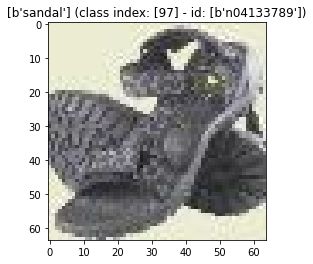

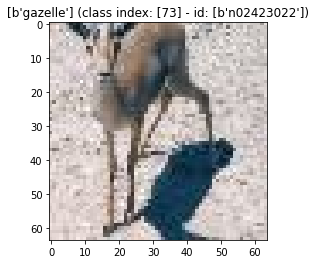

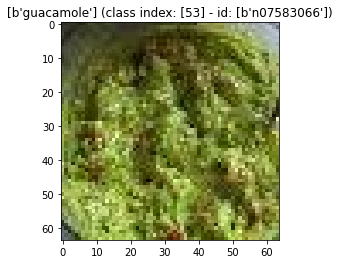

In [74]:
# TODO: Run infrence for our previous 3 sample images

# TODO: Your Code Here


for index, img_data in enumerate(sample_imgs):
    img_info(img_data)
    print(f'Image dimensions: {image.shape}')
    print(f'Image dtype: {image.dtype}')
    
    # Make a prediction
    pred = model.predict(img_data["image"])
    # print(f'Raw 200 Class Weighted Prediction:\n{pred}') # Uncomment to see the raw prediction
    
    # What is out best guess?
    best_guess = tf.math.argmax(pred, axis=1).numpy() # Our output is 200 weighted value, we want the most likely
    print(f'Best Guess [class index]: {class_names[best_guess[0]]} [{best_guess[0]}]')
    print(f'Best Guess Confidence (percent / 1.0): {pred[0][best_guess]}')

    # What are our top 15 guesses?
    top_15 = tf.math.top_k(pred, k=15)
    print(f'Top 15 Guesses (class index): {[f"{class_names[idx][0]} [{idx}]" for idx in top_15.indices[0]]}')
    print(f'Top 15 Guesses Confidence (percent / 1.0): {top_15.values}')



# for example in ds_val.batch(1).take(3):
#     img_info(example)
    
#     # Make a prediction
#     pred = model.predict(example["image"])
#     # print(f'Raw 200 Class Weighted Prediction:\n{pred}') # Uncomment to see the raw prediction
    
#     # What is out best guess?
#     best_guess = tf.math.argmax(pred, axis=1).numpy() # Our output is 200 weighted value, we want the most likely
#     print(f'Best Guess [class index]: {class_names[best_guess[0]]} [{best_guess[0]}]')
#     print(f'Best Guess Confidence (percent / 1.0): {pred[0][best_guess]}')

#     # What are our top 15 guesses?
#     top_15 = tf.math.top_k(pred, k=15)
#     print(f'Top 15 Guesses (class index): {[f"{class_names[idx][0]} [{idx}]" for idx in top_15.indices[0]]}')
#     print(f'Top 15 Guesses Confidence (percent / 1.0): {top_15.values}')

In [89]:
# TODO: Calculate the Top-1, Top-5, and Top-10 Accuracy of the validation dataset
total = acc_top1 = acc_top5 = acc_top10 = 0

# TODO: Your Code Here

for batch in ds_val.batch(32):
    top_preds = model.predict(batch['image'].numpy())
    top_10 = tf.math.top_k(top_preds, k=10).indices
    for idx, img_label in enumerate(batch['label'].numpy()):
        if img_label in top_10[idx]:
            acc_top10 += 1
    top_5 = tf.math.top_k(top_preds, k=5).indices
    for idx, img_label in enumerate(batch['label'].numpy()):
        if img_label in top_5[idx]:
            acc_top5 += 1
    top_1 = tf.math.top_k(top_preds, k=1).indices
    for idx, img_label in enumerate(batch['label'].numpy()):
        if img_label in top_1[idx]:
            acc_top1 += 1
    total += 32

print(acc_top10)
print(acc_top5)
print(acc_top1)
print(total)


1525
1268
697
10016


In [ ]:
# TODO: Print all of the possible classes of the dataset

# TODO: Your Code Here




["['Egyptian cat']", "['reel']", "['volleyball']", "['rocking chair', 'rocker']", "['lemon']", "['bullfrog', 'Rana catesbeiana']", "['basketball']", "['cliff', 'drop', 'drop-off']", "['espresso']", '[\'plunger\', "plumber\'s helper"]', "['parking meter']", "['German shepherd', 'German shepherd dog', 'German police dog', 'alsatian']", "['dining table', 'board']", "['monarch', 'monarch butterfly', 'milkweed butterfly', 'Danaus plexippus']", "['brown bear', 'bruin', 'Ursus arctos']", "['school bus']", "['pizza', 'pizza pie']", "['guinea pig', 'Cavia cobaya']", "['umbrella']", "['organ', 'pipe organ']", "['oboe', 'hautboy', 'hautbois']", "['maypole']", "['goldfish', 'Carassius auratus']", "['potpie']", "['hourglass']", "['seashore', 'coast', 'seacoast', 'sea-coast']", "['computer keyboard', 'keypad']", "['Arabian camel', 'dromedary', 'Camelus dromedarius']", "['ice cream', 'icecream']", "['nail']", "['space heater']", "['cardigan']", "['baboon']", "['snail']", "['coral reef']", "['albatros

## Model Exploration

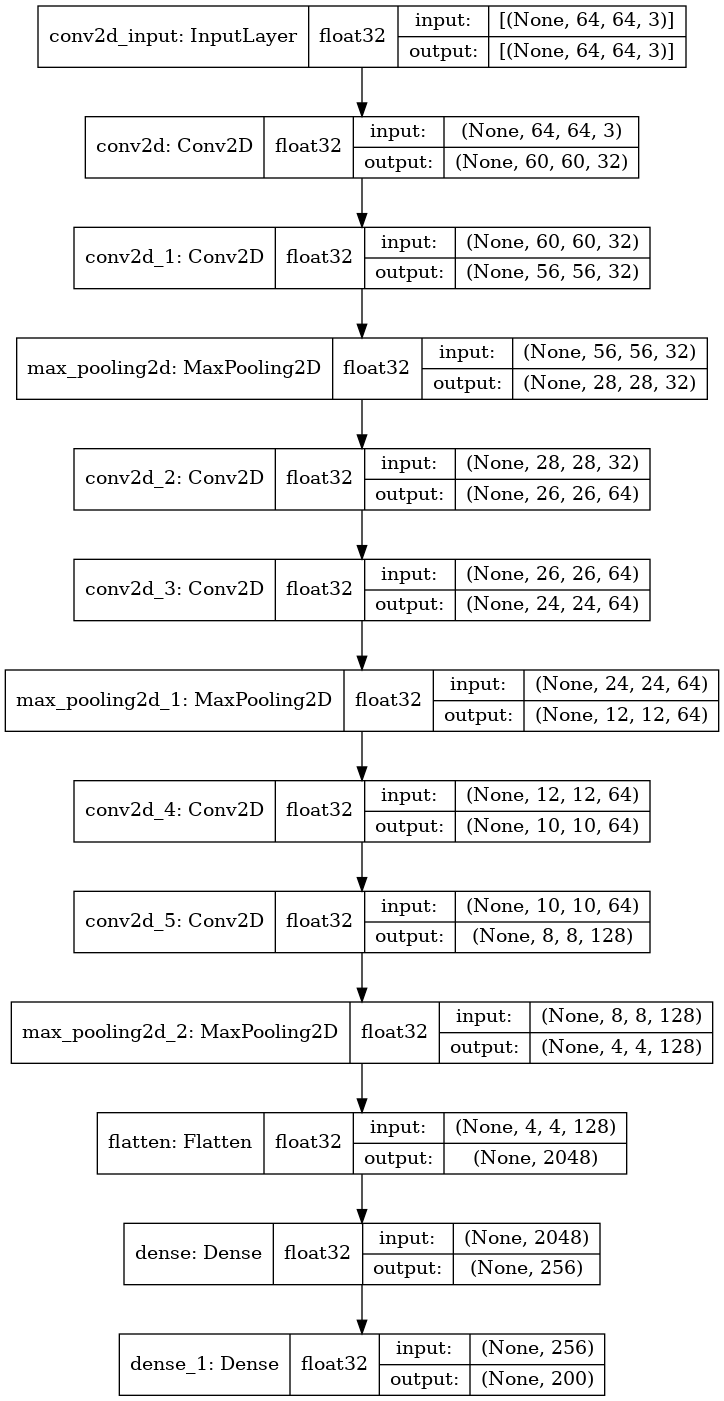

In [90]:
# TODO: Visualize the model in Netron and include an image here.
tf.keras.utils.plot_model(model, "model.png", show_shapes=True, show_dtype=True, expand_nested=True) # Uncomment this to generate an image visualization

(5, 5, 3, 32)


<Figure size 50000x50000 with 0 Axes>

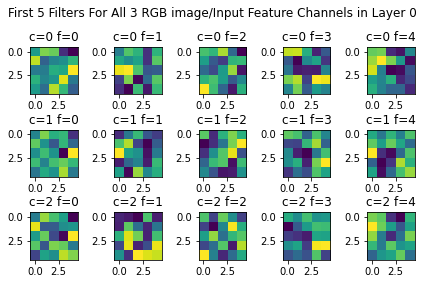

(3, 3, 64, 128)


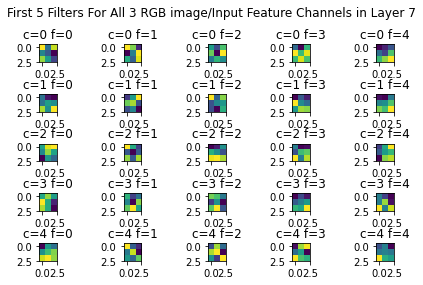

In [ ]:
# We can view the layer weights as well. Here we are pretending they are images
# TODO: Visualize the 2 convolutional layers filter sets (weights) (one at the beginning and one at the end)

# TODO: Your Code Here

---
 Image 0 ---
Conv. Layer: conv2d


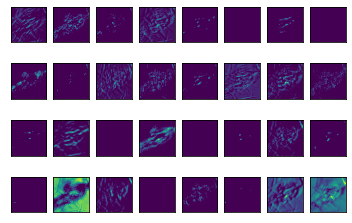

Conv. Layer: conv2d_1


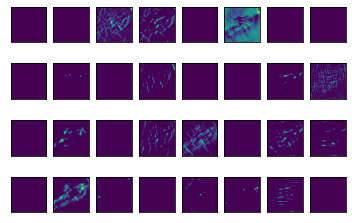

Conv. Layer: conv2d_2


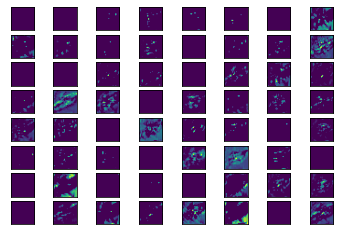

Conv. Layer: conv2d_3


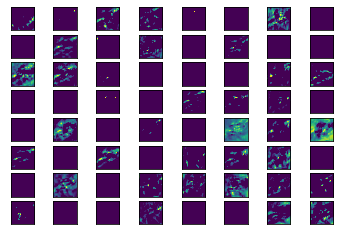

Conv. Layer: conv2d_4


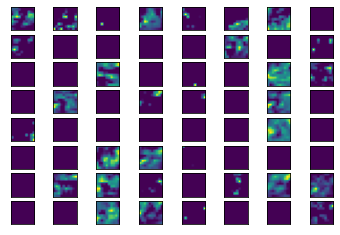

Conv. Layer: conv2d_5


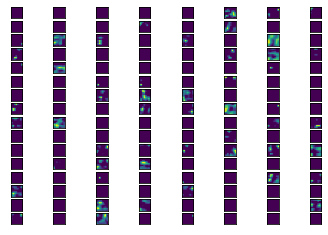

---
 Image 1 ---
Conv. Layer: conv2d


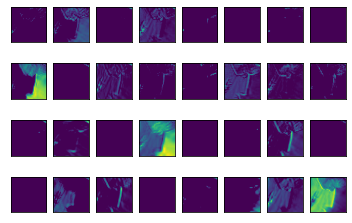

Conv. Layer: conv2d_1


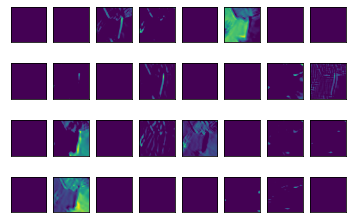

Conv. Layer: conv2d_2


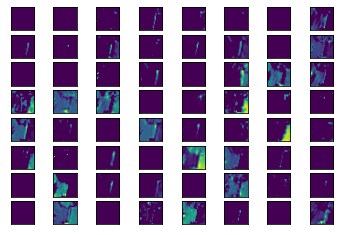

Conv. Layer: conv2d_3


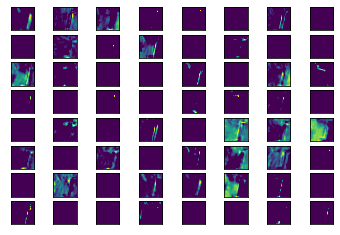

Conv. Layer: conv2d_4


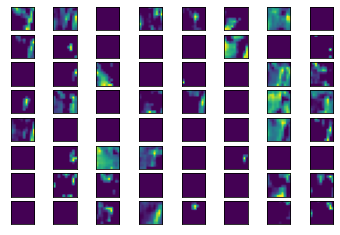

Conv. Layer: conv2d_5


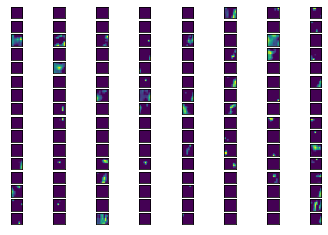

---
 Image 2 ---
Conv. Layer: conv2d


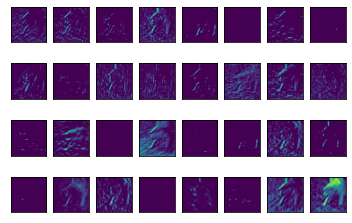

Conv. Layer: conv2d_1


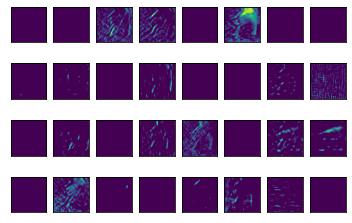

Conv. Layer: conv2d_2


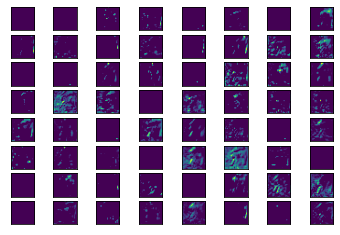

Conv. Layer: conv2d_3


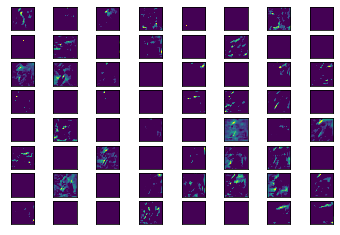

Conv. Layer: conv2d_4


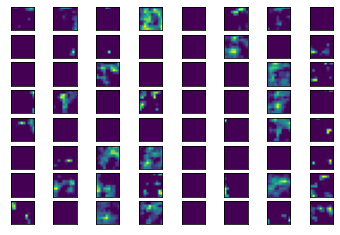

Conv. Layer: conv2d_5


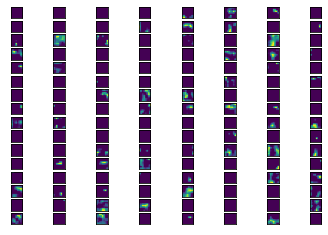

In [ ]:
# We can again view the layer outputs as well. Here we are pretending they are images
# TODO: Visualize the 2 convolutional layers outputs (intermediate feature maps) (one at the beginning and one at the end)

# TODO: Your Code Here

In [ ]:
# TODO: Export the filters/weights se we can use them later
# Make a directory for our image data
model_dir = os.path.abspath('model_data')
pathlib.Path(model_dir).mkdir(exist_ok=True)


# Export each image
conv_index = dense_index = 1 # layer index starts from one
for layer_idx, layer in enumerate(model.layers):
    if re.match("conv", layer.name):
        weight_file_name = os.path.join(model_dir, f'conv{conv_index}_weights.bin')
        bias_file_name = os.path.join(model_dir, f'conv{conv_index}_weights.bin')
        conv_index += 1
    elif re.match("dense", layer.name):
        weight_file_name = os.path.join(model_dir, f'dense{conv_index}_weights.bin')
        bias_file_name = os.path.join(model_dir, f'dense{conv_index}_weights.bin')
        dense_index += 1
    else:
        continue
        
        # TODO: Your Code Here
            
print(f"All the convolution and dense (fully connected) weights and biases successfully exported to input folders in {model_dir} directory")

All the convolution and dense (fully connected) weights and biases successfully exported to input folders in /home/mmanish/work/TA/487/lab1_testing/model_data directory


/home/mmanish/work/TA/487/lab1_testing/lab1/lib64/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
# TODO: Export the intermediate layer outputs for each of the input for all of the layers
img_dir = os.path.abspath('img_data')
pathlib.Path(img_dir).mkdir(exist_ok=True)

for img_idx, img in enumerate(sample_imgs):
    file_dir = os.path.join(img_dir, f'test_input_{img_idx}')
    pathlib.Path(file_dir).mkdir(exist_ok=True)
    
    for layer_idx, layer in enumerate(model.layers):
        aux_model = tf.keras.Model(inputs=model.inputs, outputs=[layer.output])
        
        # Store the intermediate output
        
        # TODO: Your Code Here
        
print(f"All the corresponding intermediate layer outputs successfully exported to each input folder in the {img_dir} directory")

All the corresponding intermediate layer outputs successfully exported to each input folder in the /home/mmanish/work/TA/487/lab1_testing/img_data directory


## Tensorboard

In [ ]:
# Setup for profiling
tf.profiler.experimental.ProfilerOptions(
    host_tracer_level=1, python_tracer_level=0, device_tracer_level=1
)

log_dir = os.path.abspath(os.path.join('log_data', datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))
pathlib.Path(log_dir).mkdir(exist_ok=True, parents=True)

In [ ]:
# TODO: Sample Profiling - Inference for a single image:

# Perform the inference profiling:
for example in ds_train.batch(1).take(1):
    # Starts Profile logging
    tf.profiler.experimental.start(os.path.join(log_dir, f'single-{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'))

    # Actual inference
    # TODO: Your Code Here
 
    # Stops Profile logging
    tf.profiler.experimental.stop()

# Load the TensorBoard notebook extension.
%load_ext tensorboard

# Launch TensorBoard and navigate to the Profile tab to view performance profile. 
# *** Please note just execute this command ones in a session and 
# then logs for subsequent runs would be auto detected in tensorboard- url: http://localhost:6006/
%tensorboard --logdir=log_dir

# You could view the tensorboard in the browser url: http://localhost:6006/

In [ ]:
# TODO: Sample Profiling - Online Inference:

# Vary this from 10, 100, 1000 to simulate multiple online inference
loop_index = [10, 100, 1000]

for idx in loop_index:
    # Starts Profile logging
    tf.profiler.experimental.start(os.path.join(log_dir, f'online-infrence-{idx}-{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'))

    # Actual online inference
    # TODO: Your Code Here

    # Stops Profile logging
    tf.profiler.experimental.stop()

# You could view the tensorboard in the browser url: http://localhost:6006/ and then in the profile tab navigate to the latest run.

In [ ]:
# TODO: Sample Profiling - Batch Inference:

# We would only perform batch inference for a subset of validation set i.e. 1000 images 
# using different batch sizes of 20, 40, 100, 200 

# Decides the size of the batch. Try: 20, 40, 100, 200
batch_size = [20, 40, 100, 200]

for batch in batch_size:
    # Starts Profile logging
    tf.profiler.experimental.start(os.path.join(log_dir, f'batch-{batch}-{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'))

    # Actual Batch inference
    # TODO: Your Code Here        

    # Stops Profile logging
    tf.profiler.experimental.stop()

# You could view the tensorboard in the browser url: http://localhost:6006/ and then in the profile tab navigate to the latest run.


## Training

In [ ]:
# Setup for model training
from tensorflow.keras import Model, datasets
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, ZeroPadding2D,Convolution2D, Activation, Dropout 

train_dir = os.path.abspath(os.path.join('train_data', datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))
pathlib.Path(train_dir).mkdir(exist_ok=True, parents=True)

# Using early stopping to monitor validation accuracy
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=2,
        verbose=1,
    ),
    tf.keras.callbacks.TensorBoard(log_dir=train_dir, histogram_freq=1)
]

In [ ]:
# Basic CNN model
train_model = Sequential()

# conv1
train_model.add(Conv2D(32, (5, 5), input_shape=(64, 64, 3), activation='relu'))
train_model.add(Conv2D(32, (5,5),activation='relu'))
train_model.add(MaxPooling2D(pool_size=(2, 2)))
train_model.add(Conv2D(64, (3,3), activation='relu'))
train_model.add(Conv2D(64, (3,3), activation='relu'))
train_model.add(MaxPooling2D(pool_size=(2, 2)))
train_model.add(Conv2D(64, (3,3), activation='relu'))
train_model.add(Conv2D(128, (3,3), activation='relu'))
train_model.add(MaxPooling2D(pool_size=(2, 2)))
train_model.add(Flatten())

# fc1
train_model.add(Dense(256, activation='relu'))

# fc2
train_model.add(Dense(200, activation='softmax'))

train_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
train_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 60, 32)        2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 64)        3

In [ ]:
# TODO: Attempt to train your own model with different batch sizes


def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255., label

def to_categorical(image, label):
    label = tf.one_hot(tf.cast(label, tf.int32), 200)
    return tf.cast(image, tf.float32), tf.cast(label, tf.int64)

ds_re = tiny_imagenet_builder.as_dataset(as_supervised=True)
ds_retrain, ds_reval = ds_re["train"], ds_re["validation"]

ds_retrain = ds_retrain.cache().shuffle(1024)
ds_reval = ds_reval.cache().shuffle(1024)

ds_retrain = ds_retrain.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_reval = ds_reval.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)

ds_retrain = ds_retrain.map(to_categorical, num_parallel_calls=tf.data.AUTOTUNE)
ds_reval = ds_reval.map(to_categorical, num_parallel_calls=tf.data.AUTOTUNE)

epoch_size = 20


for batch_size in [32, 64, 128]:
    # Setup our batched datasets
    # TODO: Your Code Here
    
    # Run training
    # TODO: Your Code Here
 
    # Save the cnn model
    train_model.save(os.path.join(log_dir, f'CNN_TinyImageNet_train_batch{batch_size}.h5'))

    # TODO: Get the top-1 and top-5 of your newly trained model
    # TODO: Your Code Here

<class 'tensorflow.python.data.ops.dataset_ops.ParallelMapDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
Epoch 1/20
3125/3125 [==============================] - 479s 153ms/step - loss: 5.2993 - accuracy: 0.0045 - val_loss: 5.2984 - val_accuracy: 0.0050
Epoch 2/20
3125/3125 [==============================] - 475s 152ms/step - loss: 5.2994 - accuracy: 0.0043 - val_loss: 5.2984 - val_accuracy: 0.0050
Epoch 3/20
3125/3125 [==============================] - 474s 152ms/step - loss: 5.2994 - accuracy: 0.0044 - val_loss: 5.2984 - val_accuracy: 0.0050
Epoch 4/20
3125/3125 [==============================] - 478s 153ms/step - loss: 5.2994 - accuracy: 0.0044 - val_loss: 5.2985 - val_accuracy: 0.0050
Epoch 5/20
3125/3125 [==============================] - 474s 152ms/step - loss: 5.2994 - accuracy: 0.0044 - val_loss: 5.2985 - val_accuracy: 0.0050
Epoch 6/20
3125/3125 [==============================] - 471s 1

In [ ]:
# TODO: Train your model with 3 different numbers of epochs
batch_size = 32

# Setup your datasets
# TODO: Your Code Here

for epoch_size in [3, 10, 100]:
    # Run training
    # TODO: Your Code Here

    # Save the cnn model
    train_model.save(os.path.join(log_dir, f'CNN_TinyImageNet_train_batch{batch_size}.h5'))

    # TODO: Get the top-1 and top-5 of your newly trained model
    # TODO: Your Code Here

NameError: name 'train_model' is not defined

## Above and Beyond

In [ ]:
# Benchmark our dataset to make sure loading our data isn't a bottleneck ... and because we can
# (This can be skipped since it can take a bit and is't all that important)

# tfds.benchmark(ds_train.batch(32), batch_size=32, num_iter=2**20)